In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization.hist import hist as fancyhist
#from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import scipy.stats

# defining a function that gives the values of Mirr and f
def irrotational(M, chi):
    return M*np.sqrt((1+np.sqrt(1-chi**2))/2), np.sqrt((1+np.sqrt(1-chi**2))/2)

# defining a function to compute the density of the pdf using KDE
def kde_sklearn(data, x, bandwidth, kernel):
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    return np.exp(kde_skl.score_samples(x[:, np.newaxis]))

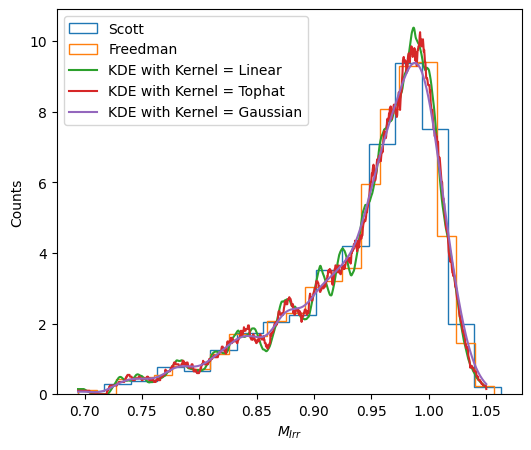

In [2]:
N=1000
mu=1
sigma=0.02
fig,ax = plt.subplots(1,1,figsize=(6,5))

# genarating the random distributions for chi and M and evaluating Mirr and f
chi = np.random.uniform(0, 1, N)
M = np.random.normal(mu, sigma, N)
M_irr, f = irrotational(M, chi)
x = np.linspace(min(M_irr), max(M_irr), N)

# plotting Mirr distribution with different techniques
scott_h = fancyhist(M_irr, bins="scott", histtype = "step", density = True, label = "Scott")
freedman_h = fancyhist(M_irr, bins="freedman", histtype = "step", density = True, label = "Freedman")

PDFlin = kde_sklearn(M_irr, x, bandwidth=0.01, kernel = "linear")
ax.plot(x, PDFlin, label = "KDE with Kernel = Linear")
PDFtophat = kde_sklearn(M_irr, x, bandwidth=0.01, kernel = "tophat")
ax.plot(x, PDFtophat, label = "KDE with Kernel = Tophat")
PDFgauss = kde_sklearn(M_irr, x, bandwidth=0.01, kernel = "gaussian")
ax.plot(x, PDFgauss, label = "KDE with Kernel = Gaussian")
ax.set(xlabel=r'$M_{Irr}$',ylabel='Counts')
ax.legend()

/home/giacomo/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


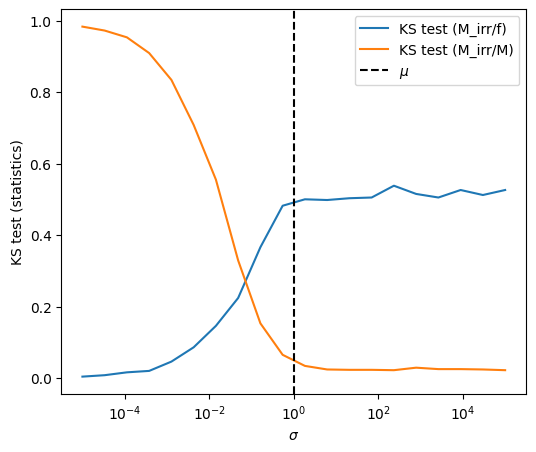

In [3]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
sigmas = np.logspace(-5,5,20)
D1=[]
D2=[]

# doung kstest for both Mirr/mu and f and for Mirr and M
for i in sigmas:
    M = np.random.normal(loc=mu, scale=i, size=N)
    M_irr, f = irrotational(M, chi)
    D1.append(scipy.stats.ks_2samp(M_irr/mu, f))
    D2.append(scipy.stats.ks_2samp(M_irr, M))
    
# plotting the statitics from the KStests
D1=np.array(D1)
D2=np.array(D2)
ax.plot(sigmas, D1[:,0], label = "KS test (M_irr/f)")
ax.plot(sigmas, D2[:,0], label = "KS test (M_irr/M)")
ax.axvline(mu,color='black',linestyle='--',label=r'$\mu$')
ax.set(xlabel=r'$\sigma$',ylabel='KS test (statistics)',xscale='log')
ax.legend()

/tmp/ipykernel_9024/1334577443.py:4: RuntimeWarning: divide by zero encountered in divide
  return 2*(2*f**2-1)/np.sqrt(1-f**2)


KstestResult(statistic=0.023767409508107296, pvalue=0.6157475383756404, statistic_location=0.9983332453401268, statistic_sign=-1)


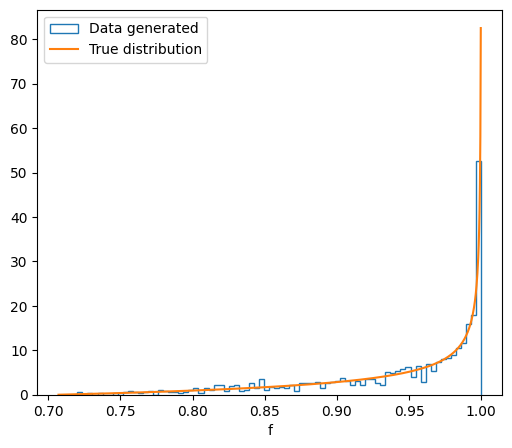

In [ ]:
from scipy.integrate import quad
# plotting the distribution for f
def f_pdf(f):
    return 2*(2*f**2-1)/np.sqrt(1-f**2)

# defining the cdf to compute a kstest
def f_cdf(x):
    a=1/np.sqrt(2)
    b=1
    Z = quad(f_pdf, a, b)[0]
    cdf_vals = np.zeros_like(x, dtype=float)
    for i, xi in enumerate(x):
        if xi <= a:
            cdf_vals[i] = 0.0
        elif xi >= b:
            cdf_vals[i] = 1.0
        else:
            I = quad(f_pdf, a, xi)[0]
            cdf_vals[i] = I / Z
    return cdf_vals if len(cdf_vals) > 1 else cdf_vals[0]

chi = np.random.uniform(0, 1, N)
M = np.random.normal(mu, sigma, N)
M_irr, f = irrotational(M, chi)

x=np.linspace(1/np.sqrt(2),1,N)

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.hist(f,density=True,histtype='step',bins=80,label='Data generated')
ax.plot(x,f_pdf(x),label='True distribution')
ax.set(xlabel='f')
ax.legend()
print(scipy.stats.kstest(f,f_cdf))

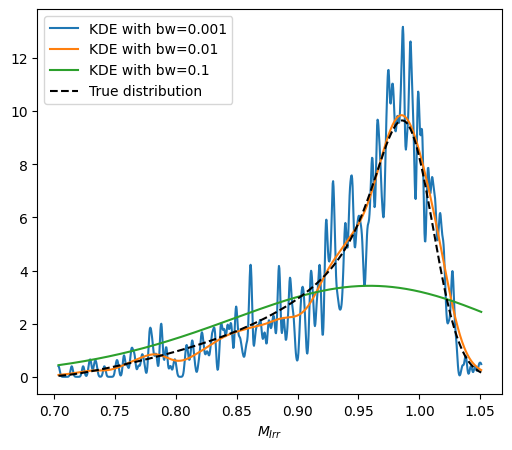

In [ ]:
# plotting the distribution for Mirr

def integrand(Mirr,f,sigma,mu):
    return ( np.sqrt(2/np.pi)/sigma * np.exp(-(Mirr/f-mu)**2/(2*sigma**2)) * (2*f**2-1)/(f*np.sqrt(1-f**2)) )

x = np.linspace(min(M_irr), max(M_irr), N)
y=[quad(lambda f : integrand(Mi,f,sigma,mu),1/np.sqrt(2),1)[0] for Mi in x]
fig,ax=plt.subplots(1,1,figsize=(6,5))
for bw in [0.001,0.01,0.1]:
    PDFgauss = kde_sklearn(M_irr, x, bandwidth=bw, kernel = "gaussian")
    ax.plot(x, PDFgauss, label=f'KDE with bw={bw}')
ax.plot(x,y,color='k',linestyle='--',label='True distribution')
ax.set(xlabel=r'$M_{Irr}$')
ax.legend()